<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/Hometasks/Base/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

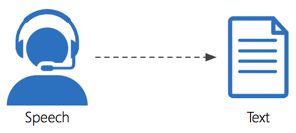

In [1]:
%mkdir -p /content/host/
%cd /content/host/
%ls

/content/host
all_pairs_1.json  data_russian_speech/               wav2vec2-large-ru-golos/
all_pairs_2.json  models/                            whisper/
all_pairs_3.json  result_array.json                  whisper-large/
all_pairs_4.json  russian_spell_correction_dataset/  whisper-large-v3/
all_pairs.json    urls_normalized.tsv


In [2]:
# Установка всех необходимых пакетов
%pip install -q pandas transformers datasets torchaudio torcheval evaluate openai huggingface_hub accelerate dotenv matplotlib

# не обновлять pandas выше 2.2.2 - требуется для Google Collab

## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [3]:
import os
import random
import time
import csv
import torch
import json
import torchaudio
import requests
from tqdm.auto import tqdm
from pathlib import Path
from transformers import WhisperProcessor, WhisperForConditionalGeneration

### Загрузим список URL с файлами датасета

In [4]:
# предварительно сохранить файл https://disk.yandex.ru/d/v2Hipv7XG4fEDQ как `urls_normalized.tsv`

DATA_ROOT = Path("data_russian_speech")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
TSV_PATH = Path("./urls_normalized.tsv")

urls = []

if TSV_PATH.exists():
    with TSV_PATH.open("r", encoding="utf-8") as f:
        tsv_reader = csv.reader(f, delimiter="\t")
        for row in tsv_reader:
            urls.append(row[0].strip())
    print(f"Найдено {len(urls)} URL для скачивания.")
else:
    print("Скачайте файл https://disk.yandex.ru/d/v2Hipv7XG4fEDQ как `urls_normalized.tsv`")

Найдено 100 URL для скачивания.


### Скачаем аудио-файлы

In [5]:
def download_file(url: str, dest_path: Path, verbose=False):
    """Загрузка одного файла (с прогресс-баром)."""
    filename = url.split("/")[-1] + ".wav"
    target_file = dest_path / filename

    if target_file.is_file():
        if verbose:
            print(f"- Уже существует: {filename}")
        return

    # Потоковое скачивание, чтобы не грузить много в память
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with tqdm(total=total, unit="B", unit_scale=True, desc=filename) as pbar:
            with open(target_file, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:  # могут быть пустые - keep-alive
                        f.write(chunk)
                        pbar.update(len(chunk))

    if verbose:
        print(f"+ Загружен: {filename}")


for url in tqdm(urls, total=len(urls)):
    try:
        download_file(url, DATA_ROOT)
    except Exception as e:
        print(f"Х Ошибка загрузки {url}: {e}")

  0%|          | 0/100 [00:00<?, ?it/s]

### Вспомогательные функции загрузки аудио-файлов

In [6]:
import wave
import numpy as np
import gc


# Очистка памяти, чтобы влезло на Т5 в Google Colab
def model_cleanup(model, processor=None):
    model.to("cpu")
    del model
    if processor is not None:
        del processor
    torch.cuda.empty_cache()
    gc.collect()


# Считывание WAV-файла и получение тензора PyTorch
def load_wav_file(filepath):
    """Считывание WAV-файла и получение тензора PyTorch"""
    with wave.open(filepath, "rb") as wav_file:
        # Параметры аудиофайла
        channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        frames = wav_file.getnframes()

        # Считаем аудиоданные
        raw_audio = wav_file.readframes(frames)

        # Конвертируем в numpy array
        if sample_width == 1:
            dtype = np.uint8
        elif sample_width == 2:
            dtype = np.int16
        elif sample_width == 4:
            dtype = np.int32
        else:
            raise ValueError(f'Неподдерживаемый "sample width": {sample_width}')

        audio_data = np.frombuffer(raw_audio, dtype=dtype)

        # Reshape, если многоканальное аудио
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)

        # Нормализация к диапазону [-1, 1]
        if dtype == np.uint8:
            audio_data = (audio_data.astype(np.float32) - 128) / 128
        else:
            audio_data = audio_data.astype(np.float32) / np.iinfo(dtype).max

        tensor = torch.from_numpy(audio_data)

        # Приведение к структуре (channels, samples) для PyTorch
        if len(tensor.shape) == 1:
            tensor = tensor.unsqueeze(0)  # добавить измерение
        else:
            tensor = tensor.transpose(
                0, 1
            )  # переставить измерения (samples, channels) -> (channels, samples)

        return tensor, framerate


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# тестовый
audio_tensor, sample_rate = load_wav_file(
    "./data_russian_speech/00760e69-35b8-4c65-84f6-c1d0e82907c2.wav"
)
audio_tensor = audio_tensor.to(device)

print(f"Загружено: {audio_tensor.shape} @ {sample_rate}Hz")

model_cleanup(audio_tensor)

Загружено: torch.Size([1, 36160]) @ 16000Hz


In [7]:
def load_audio(path: str, target_sr: int = 16000):
    wav, sr = load_wav_file(path)
    # Многоканальное усредним до "моно"
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    # пересэмплируйте имеющиеся аудио в 16 kHz - пример кода ниже, можете его менять
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=target_sr)
        sr = target_sr
    return wav.squeeze(0), sr

### Ключи и токены

Следующая ячейка инициализирует ключи доступа к OpenRouter и HuggingFace.  
Ключи считываются либо из секретов Google Collab (если достпен), либо из локального файла `.env`

In [8]:
from dotenv import load_dotenv
# from google.colab import userdata

try:
    # Если в Google Colab, то используем userdata
    API_KEY = google.colab.userdata.get("OPENROUTER_API_KEY")
    HF_TOKEN = google.colab.userdata.get("HF_TOKEN")
except Exception as e:  # если нет usertada, то будет исключение
    # Тогда читаем из .env файла в текущей директории /content/host/
    load_dotenv()
    API_KEY = os.getenv("OPENROUTER_API_KEY")
    HF_TOKEN = os.getenv("HF_TOKEN")

# Для теста можно задать ключи вручную
if API_KEY is None:
    API_KEY = "---- ВПИШИТЕ СЮДА КЛЮЧ ----"
if HF_TOKEN is None:
    HF_TOKEN = "---- ВПИШИТЕ СЮДА КЛЮЧ ----"

os.environ["OPENROUTER_API_KEY"] = API_KEY
os.environ["HF_TOKEN"] = HF_TOKEN

### Подготовка модели Whisper

In [9]:
def process_audio_files(
    model,
    processor,
    wav_files_path: str | Path,
    output_path: str | Path,
    language="ru",
    task="transcribe",
) -> list[Path]:
    """
    Функция для обработки аудиофайлов моделью типа Whisper

    Параметры:
    - model: модель для транскрипции
    - processor: процессор для обработки аудио
    - wav_files_path: путь к папке с wav файлами (str или Path)
    - output_path: путь к папке для сохранения результатов (str или Path)
    - language: язык для транскрипции (по умолчанию "ru")
    - task: задача (по умолчанию "transcribe")

    Возвращает:
    - список путей к созданным txt файлам ([Path])
    """

    # Преобразуем пути в Path объекты
    wav_path = Path(wav_files_path)
    output_path = Path(output_path)

    # Создаем папку для результатов если её нет
    output_path.mkdir(parents=True, exist_ok=True)

    # Находим все wav файлы
    wav_paths = list(wav_path.rglob("*.wav"))

    print(f"Найдено {len(wav_paths)} аудиофайлов для обработки")

    created_files = []

    for i, p in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        try:
            # Загружаем аудио
            wav, sr = load_audio(str(p))

            # Обрабатываем аудио через процессор
            inputs = processor(wav, sampling_rate=sr, return_tensors="pt")
            input_features = inputs.input_features.to(model.device)

            # Создаем attention_mask если его нет
            if hasattr(inputs, "attention_mask") and inputs.attention_mask is not None:
                attention_mask = inputs.attention_mask.to(model.device)
            else:
                # Создаем маску внимания для всех элементов (все единицы)
                attention_mask = torch.ones(
                    input_features.shape[:2], dtype=torch.long, device=model.device
                )

            # Генерация выходных токенов
            predicted_ids = model.generate(
                input_features,
                attention_mask=attention_mask,
                language=language,
                task=task,
            )

            # Декодирование в текст
            transcription = processor.batch_decode(
                predicted_ids, skip_special_tokens=True
            )[0]

            # Сохраняем транскрипцию в файл
            txt_filename = (
                p.stem + ".txt"
            )  # p.stem дает имя файла без пути и без расширения
            txt_path = output_path / txt_filename
            txt_path.write_text(transcription, encoding="utf-8")

            created_files.append(txt_path)

        except Exception as e:
            print(f"Ошибка при обработке файла {p.name}: {str(e)}")
            continue

    print("Все файлы обработаны!")
    return created_files

> При наличии токена HF_TOKEN почему-то иногда подключение к HF зависает.
> Помогает перезапуск ячейки.

In [10]:
model_name_whisper = "openai/whisper-small"
processor_whisper = WhisperProcessor.from_pretrained(model_name_whisper, cache_dir="./models")
model_whisper = WhisperForConditionalGeneration.from_pretrained(model_name_whisper, cache_dir="./models").to(device)
model_whisper.eval()

# Используем функцию для обработки файлов
created_files = process_audio_files(
    model=model_whisper,
    processor=processor_whisper,
    wav_files_path="data_russian_speech",  # путь к папке с wav файлами
    output_path="whisper/txt",  # папка для сохранения результатов
    language="ru",  # язык транскрипции
    task="transcribe",  # задача
)

# Очистка памяти
model_cleanup(model_whisper, processor_whisper)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Найдено 100 аудиофайлов для обработки


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы обработаны!


### Отображение 10 рандомных транскрипций

In [11]:
sample_txt_files = random.sample(created_files, k=min(10, len(created_files)))

print("10 случайных транскрипций:")
print("=" * 50)

for txt_file in sample_txt_files:
    transcription = txt_file.read_text(encoding="utf-8").strip()
    print(f"{txt_file.name} : {transcription}")

10 случайных транскрипций:
8eec6bf4-818c-4852-8063-0bcc5d2e7175.txt : Угладиатор
703e7d9c-b170-4762-b5d3-c4fa8e4be0e8.txt : Николай Каперник
d5bd3785-733a-4a95-b3ba-4d80ece002ee.txt : Однажды в Америке
163e0da8-750f-45d4-b5d5-8982fb060c12.txt : Новый кинотеатр пародизо
ce29f3d2-8c47-4466-a2b5-7bcb73b0eb02.txt : двое
5fdd45c8-59c9-4c90-bf81-e426cf597f40.txt : Жулианна Мур
2a6d78d6-5b79-4ec1-bd9b-29b59c1960c1.txt : Дай не трехо.
fcceeeb4-5bb7-460a-853c-99c3c7bd5aef.txt : Андрей Сахаров
53085fa6-1df6-4d46-ae00-4ce2b89ac0ca.txt : Интерстеллер
871a6ddc-77b3-45e0-ab4d-2bdcddb78515.txt : Звездной войны. Эпизод 5. Империя наносит ответный удар.


## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [12]:
# ваш код здесь
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_name_t5 = "UrukHan/t5-russian-spell"
t5_tokenizer = AutoTokenizer.from_pretrained(model_name_t5, cache_dir="./models")
t5_model = AutoModelForSeq2SeqLM.from_pretrained(model_name_t5, cache_dir="./models").to(device)
t5_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [13]:
# тестовый
input_ids = t5_tokenizer("Полмакартни", return_tensors="pt").input_ids.to(device)
outputs = t5_model.generate(input_ids)
print(t5_tokenizer.decode(outputs[0], skip_special_tokens=True))

Пол Маккартни


In [14]:
def correct_text_files(
    model, tokenizer, input_files: list[Path], output_path: Path, input_prefix=None, suffix="_corrected"
):
    """
    Функция для исправления текста в файлах с помощью модели

    Параметры:
    - model: модель для исправления текста
    - tokenizer: токенизатор для модели
    - input_files: список путей к txt файлам для исправления
    - output_path: путь к папке для сохранения исправленных файлов
    - suffix: суффикс для имен исправленных файлов (по умолчанию "_corrected")

    Возвращает:
    - список путей к созданным исправленным файлам
    """

    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)

    print(f"Найдено {len(input_files)} файлов для исправления")

    corrected_files = []

    for txt_file in tqdm(input_files, total=len(input_files)):
        try:
            transcription = txt_file.read_text(encoding="utf-8").strip()

            if input_prefix:
                transcription = input_prefix + transcription

            # Токенизируем и генерируем исправленный текст
            input_ids = tokenizer(transcription, return_tensors="pt").input_ids.to(
                model.device
            )
            outputs = model.generate(input_ids)
            corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Сохраняем исправленный текст в файл
            new_filename = Path(txt_file).stem + suffix + ".txt"
            new_path = output_path / new_filename
            new_path.write_text(corrected_text, encoding="utf-8")

            corrected_files.append(new_path)

        except Exception as e:
            print(f"Ошибка при исправлении файла {txt_file}: {str(e)}")
            continue

    print("Все файлы исправлены!")
    return corrected_files

In [15]:
# Используем функцию для исправления файлов
corrected_files = correct_text_files(
    model=t5_model,
    tokenizer=t5_tokenizer,
    input_files=created_files,  # список путей к txt файлам для исправления
    output_path="whisper/t5",  # папка для сохранения исправленных файлов
    suffix="",  # суффикс для имен файлов
)

model_cleanup(t5_model, t5_tokenizer)

Найдено 100 файлов для исправления


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы исправлены!


In [16]:
sample_corrected_files = random.sample(corrected_files, k=min(10, len(corrected_files)))

print('10 случайных "исправлений" вида            [whisper | whisper+T5]')
print("=" * 80)

for txt_file in sample_corrected_files:
    transcription_corrected = txt_file.read_text(encoding="utf-8").strip()
    transcription = (
        (txt_file.parent.parent / "txt" / txt_file.name)
        .read_text(encoding="utf-8")
        .strip()
    )
    # .read_text(encoding='utf-8').strip()
    print(f"{txt_file.name} | {transcription} | {transcription_corrected}")

10 случайных "исправлений" вида            [whisper | whisper+T5]
37e917e1-1fdf-4064-a74f-57a84bcb28b9.txt | Золотая лихорадка. | Золотая лихорадка
d203c652-509b-4c41-bdaf-f374e1c3c87e.txt | Служебный реман | Служебный роман
4c0f8f80-99f2-4dba-b54f-1860e07af180.txt | Гарри Поттер и дары смерти, части два. | Гарри Поттер и Дары Смерти (часть 2)
6322d6cd-0928-4b4d-b96d-7cf78a86d7e6.txt | Фернандо Баторо | Фернандо Баторо
236b63a8-8f37-444d-8340-25324620e985.txt | адвокат делала | Делала адвокат.
0b495d2e-a15e-4ee6-8283-316fb821abf2.txt | Унесённый ветром. | Унесённый ветром.
2e069c1d-11ba-4a51-84b1-f182b8a2999a.txt | Олеша Юрий Карлович | Олеша Юрий Карлович
0a450eae-9d55-4bf0-aba8-a6f2e1162706.txt | Огни большого города | Огни большого города
5baa289b-4373-47ff-8203-4462e052510f.txt | Джерард Батлер | Джерард Батлер
6b061312-1923-4924-97de-21e31d6f5861.txt | Синявский Андрей Донатович | Синявский Андрей Донатович


## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

### Проверка подключения к OpenRouter

Все использованные ниже модели бесплатные.

In [17]:
from openai import OpenAI

# MODEL_NAME = "deepseek/deepseek-chat-v3.1:free"
# MODEL_NAME = "moonshotai/kimi-k2:free"
# MODEL_NAME = "alibaba/tongyi-deepresearch-30b-a3b:free"  # быстрый, но не точный
# MODEL_NAME = "qwen/qwen3-235b-a22b:free"
MODEL_NAME = "meituan/longcat-flash-chat:free"

client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=API_KEY)

completion = client.chat.completions.create(
    # extra_headers={
    #   "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    #   "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
    # },
    model=MODEL_NAME,
    messages=[{"role": "user", "content": "Привет! Поработаем сегодня?"}],
)

print(completion.choices[0].message.content)
time.sleep(3)  # чтобы следующая ячейка не отвалилась по rate-limit

Привет! 😊 Конечно, давай поработаем — с удовольствием помогу тебе сегодня! Расскажи, пожалуйста, что планируем?  

Хочешь:  
- Решить задачи/вопросы?  
- Обсудить идеи/проект?  
- Поработать с текстом (речь, статья, код)?  
- Что-то другое?  

Также могу слушать в формате "рассказываю — уточняю — вместе анализируем". Делись деталями, и я постараюсь сделать процесс полезным и веселым 🚀  

(Если срочно — напиши "Горит!", и я включу турборежим 🔥)


### Вспомогательные функции

In [18]:
# Функйция генерации пар (ошибка -> исправление) для обучения модели
def generate_spell_correction_pairs(num_pairs=50):
    """
    Генерирует пары (ошибка -> исправление) для обучения модели spell correction
    """
    prompt = """
Ты эксперт по русскому языку. Создай {num_pairs} пар (ошибка -> исправление) для обучения модели spell correction.
Верни результат в формате JSON с массивом пар.

КРИТИЧЕСКИ ВАЖНО: 
- Отвечай ТОЛЬКО в формате JSON
- НЕ добавляй никаких объяснений, рассуждений или комментариев
- НЕ пиши "Вот пары:" или подобные фразы
- Начинай ответ сразу с {{

ПРАВИЛА:
- Ошибка и исправление должны быть разными
- Ошибки должны быть типичными для speech-to-text систем (фонетические ошибки, пропуски букв, замены)
- Используй разнообразные типы ошибок: пропуски букв, замены, перестановки, лишние буквы
- Включай имена собственные, географические названия, научные термины, короткие фразы, названия фильмов, книг, песен, игр, сериалов, мультфильмов, и т.д.
- Длина текстов от 1 до 5 слов
- Ошибки должны быть реалистичными для русской речи
- Не используй кавычки, эмодзи, спецсимволы, HTML-теги, markdown, latex, математические формулы, химические формулы, биологические формулы, физические формулы, и т.д.
""".format(num_pairs=num_pairs)

    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=MODEL_NAME,
            temperature=0.6,
            max_tokens=10000,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "spell_correction_pairs",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "pairs": {
                                "type": "array",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "error": {"type": "string"},
                                        "correction": {"type": "string"},
                                    },
                                    "required": ["error", "correction"],
                                    "additionalProperties": False,
                                },
                            }
                        },
                        "required": ["pairs"],
                        "additionalProperties": False,
                    },
                },
            },
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Ошибка при генерации: {e}")
        return None


def parse_generated_pairs(text):
    """
    Парсит сгенерированный текст и извлекает пары (ошибка, исправление)
    """
    pairs = []
    lines = text.strip().split("\n")

    current_error = None
    current_correction = None

    for line in lines:
        line = line.strip()
        if line.startswith("ОШИБКА:"):
            current_error = line.replace("ОШИБКА:", "").strip()
        elif line.startswith("ИСПРАВЛЕНИЕ:"):
            current_correction = line.replace("ИСПРАВЛЕНИЕ:", "").strip()
            if (
                current_error
                and current_correction
                and current_error != current_correction
            ):
                pairs.append((current_error, current_correction))
                current_error = None
                current_correction = None

    return pairs


def parse_structured_pairs(json_text):
    """
    Парсит JSON ответ и извлекает пары (ошибка, исправление)
    """

    import json

    try:
        data = json.loads(json_text)
        pairs = []
        for pair in data.get("pairs", []):
            if (
                "error" in pair
                and "correction" in pair
                and pair["error"].lower() != pair["correction"].lower()
            ):
                pairs.append((pair["error"], pair["correction"]))
        return pairs
    except json.JSONDecodeError as e:
        print(f"Ошибка парсинга JSON: {e}")
        return []
    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")
        return []

### Тестовый запуск

In [19]:
# test
json_response = generate_spell_correction_pairs(10)
if json_response:
    pairs = parse_structured_pairs(json_response)
    print(f"Получено {len(pairs)} пар:")
    for error, correction in pairs[:5]:
        print(f"{error} => {correction}")

time.sleep(5)  # чтобы следующая ячейка не отвалилась по rate-limit

Получено 4 пар:
жили были => жили-были
супермана => Супермен
звездные войны => Звёздные войны
темная башня => Тёмная башня


### Генерируем пары

Эту ячейку запускать не обязательно, т.к. датасет уже сформирован и загружен на Hugging Face  
https://huggingface.co/datasets/psaw77/russian-spell-correction-dataset

При желании можно запустить всё, тогда сформируется еще несколько пар и добавится к датасету.

In [20]:
RUN_NEW_GENERATION = False


# Генерируем данные батчами, чтобы не превысить лимиты
# промежуточные результаты сохраняются в файлы,
# чтобы не терять данные от прошлых запусков
all_pairs = []

if RUN_NEW_GENERATION:
    batch_size = 10
    total_pairs_needed = 10  # было несколько запусков по 1500 пар
    num_batches = (total_pairs_needed // batch_size) + 1

    print(f"Генерируем {total_pairs_needed} пар в {num_batches} батчах...")

    with tqdm(total=num_batches, desc="Генерация батчей") as pbar:
        for batch in range(num_batches):
            generated_text = generate_spell_correction_pairs(batch_size)
            if generated_text:
                pairs = parse_structured_pairs(generated_text)
                all_pairs.extend(
                    pairs
                )  # сохраняем текущее состояние в файл для защиты от сбоев
                import json

                with open("all_pairs.json", "w", encoding="utf-8") as f:
                    json.dump(all_pairs, f, ensure_ascii=False, indent=2)
                pbar.set_postfix(
                    {"Получено в батче": len(pairs), "Всего пар": len(all_pairs)}
                )

                # Небольшая пауза между запросами
                time.sleep(random.randint(7, 12))
            else:
                st = random.randint(30, 40)
                pbar.set_postfix({"Статус": f"Ошибка в генераци... sleep {st} сек"})
                time.sleep(st)
                pbar.set_postfix({"Статус": "Ошибка в генераци... continue"})

            pbar.update(1)

            # Останавливаемся, если набрали достаточно пар
            if len(all_pairs) >= total_pairs_needed:
                break

print(f"Итого собрано {len(all_pairs)} пар")

# Пример того, что собрано в этом запуске
random.sample(all_pairs, k=min(10, len(all_pairs)))

Итого собрано 0 пар


[]

> Если в этот раз получился бред, а такое бывает, то просто удалить файл `all_pairs.json`

### Собираем сохраненные промежуточные файлы

На моем сервере уже сохранены несколько файлов, содержащие 1500+ пар

In [21]:
import pandas as pd


all_pairs = []

# Считываем все промежуточные файлы
for file in Path(".").glob("all_pairs*.json"):
    all_pairs.extend(json.loads(file.read_text(encoding="utf-8")))

print(f"Из промежуточных файлов собрано {len(all_pairs)} пар")

# Делаем из списка пар датафрейм
df = pd.DataFrame(all_pairs, columns=["input", "target"])

# Удаляем дубликаты
df = df.drop_duplicates()

# Сохраняем в CSV с автоинкрементом номера файла
base_filename = "spell_correction_dataset"
counter = 1
csv_path = DATA_ROOT / f"{base_filename}_{counter}.csv"

while csv_path.exists():
    counter += 1
    csv_path = DATA_ROOT / f"{base_filename}_{counter}.csv"

df.to_csv(csv_path, index=False, encoding="utf-8")
print(f"Датасет сохранен в {csv_path}")
print(f"После удаления дубликатов: {len(df)} пар")
print("\nПримеры:")
print(df.head(10))

Из промежуточных файлов собрано 1516 пар
Датасет сохранен в data_russian_speech/spell_correction_dataset_25.csv
После удаления дубликатов: 1326 пар

Примеры:
                                input                             target
0                  Василевский остров                Васильевский остров
1                             Матрици                            Матрица
2                              Превед                             Привет
3                             Айнштан                           Эйнштейн
4  Гарри Поттер и философсвкий камень  Гарри Поттер и философский камень
5                               Метла                             Металл
6                             здарова                       здравствуйте
7                        запрограмист                        программист
8                         алгебралайн                     алгебраический
9                     нано технологии                     нанотехнологии


### Сохраняем/обновляем датасет на HuggingFace  
На момент написания там уже 1600+ строк (пар)  
https://huggingface.co/datasets/psaw77/russian-spell-correction-dataset

**Порядок действий**:
- скачать, если существует,
- добавить новые пары,
- загрузить обратно

In [22]:
# from huggingface_hub import login
# login(token=HF_TOKEN) # не нужно, если токен уже в переменных окружения, а он там

> По непонятной причине обращение к HuggingFace иногда подвисает.  
> Обычно выполняется почти моментально.  
> Если дольше 5 секунд - вручную остановить и заново запустить.

In [23]:
from datasets import Dataset, load_dataset


try:
    print("Попытка загрузки существующего датасета...")

    # если датасета нет, то это вызовет исключение
    existing_dataset = load_dataset("psaw77/russian-spell-correction-dataset", )
    print(f"Найден существующий датасет с {len(existing_dataset['train'])} записями")

    existing_df = existing_dataset["train"].to_pandas()
    new_df = df.copy()  # датафрейм из локальных файлов

    # Индексы не нужны. HF их пересоздаст
    if "__index_level_0__" in existing_df.columns:
        existing_df = existing_df.drop(columns=["__index_level_0__"])
    if "__index_level_0__" in new_df.columns:
        new_df = new_df.drop(columns=["__index_level_0__"])

    # Объединяем датасеты
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)

    # Удаляем дубликаты
    print(f"До удаления дубликатов: {len(combined_df)} записей")
    combined_df = combined_df.drop_duplicates(subset=["input", "target"])
    print(f"После удаления дубликатов: {len(combined_df)} записей")

    dataset = Dataset.from_pandas(combined_df)

except Exception as e:
    print(f"Ошибка при загрузке существующего датасета: {e}")
    print("Создаем новый датасет...")

    dataset = Dataset.from_pandas(df)

# Сохраняем локально - может пригодиться
dataset.save_to_disk("russian_spell_correction_dataset")
print("HuggingFace dataset сохранен локально")

# Отправляем в HuggingFace Hub
dataset.push_to_hub("psaw77/russian-spell-correction-dataset")
print("Датасет загружен в HuggingFace Hub!")

Попытка загрузки существующего датасета...
Найден существующий датасет с 1637 записями
До удаления дубликатов: 2963 записей
После удаления дубликатов: 1637 записей


Saving the dataset (0/1 shards):   0%|          | 0/1637 [00:00<?, ? examples/s]

HuggingFace dataset сохранен локально


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 57.9kB / 57.9kB            

No files have been modified since last commit. Skipping to prevent empty commit.


Датасет загружен в HuggingFace Hub!


## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [24]:
# %pip install --upgrade transformers datasets  # Уже установлено в первой ячейке

### Модель для дообучения - та же, что и в шаге 2

In [25]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

# Модель
model_name_4 = "UrukHan/t5-russian-spell"
t5_ft_tokenizer = AutoTokenizer.from_pretrained(model_name_4, cache_dir="./models")
t5_ft_model = AutoModelForSeq2SeqLM.from_pretrained(model_name_4, cache_dir="./models").to(device)
t5_ft_model.eval()


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### Подготовка данных

In [26]:
# если работает дольше 5 секунд - прервать и повторить
# login(token=HF_TOKEN)
full_dataset_2 = load_dataset("psaw77/russian-spell-correction-dataset")
dataset_2 = full_dataset_2["train"].train_test_split(test_size=0.1)
dataset_2

DatasetDict({
    train: Dataset({
        features: ['input', 'target', '__index_level_0__'],
        num_rows: 1473
    })
    test: Dataset({
        features: ['input', 'target', '__index_level_0__'],
        num_rows: 164
    })
})

### Выбор `max_length` для токенизатора

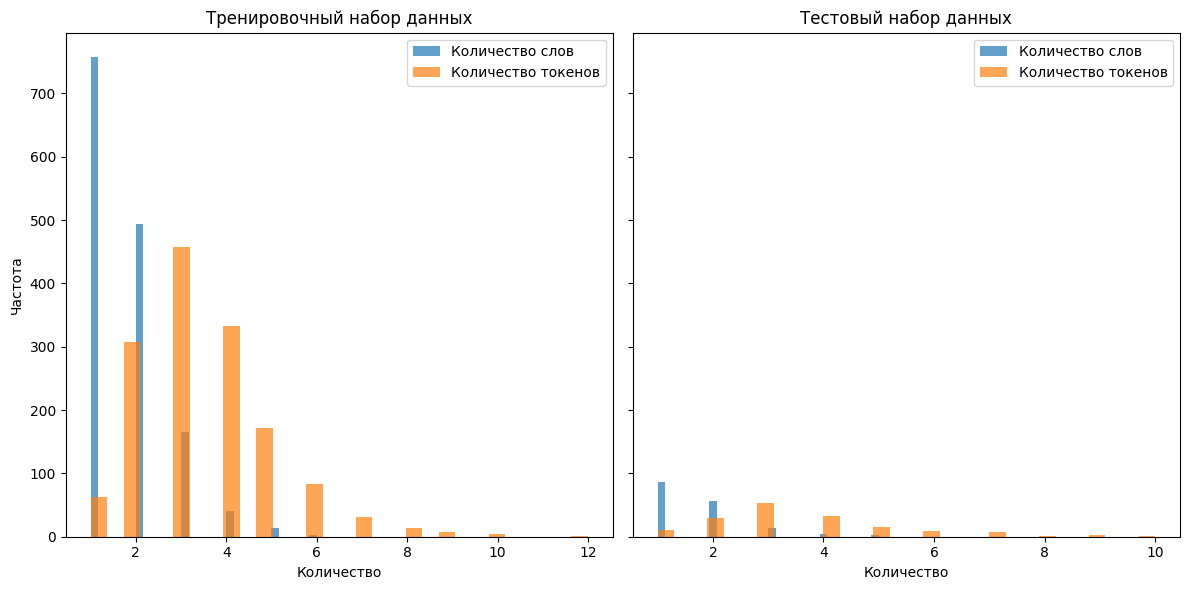

In [27]:
import matplotlib.pyplot as plt

# Подсчет количества слов и токенов с использованием токенизатора
train_word_counts = [len(example["input"].split()) for example in dataset_2["train"]]
train_token_counts = [
    len(t5_ft_tokenizer.tokenize(example["input"])) for example in dataset_2["train"]
]

test_word_counts = [len(example["input"].split()) for example in dataset_2["test"]]
test_token_counts = [
    len(t5_ft_tokenizer.tokenize(example["input"])) for example in dataset_2["test"]
]

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[0].set_title("Тренировочный набор данных")
axes[0].set_xlabel("Количество")
axes[0].set_ylabel("Частота")
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(test_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[1].hist(test_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[1].set_title("Тестовый набор данных")
axes[1].set_xlabel("Количество")
axes[1].legend()

plt.tight_layout()
plt.show()

> Пусть будет 12

In [28]:
MAX_LENGTH = 12

In [29]:
# Токенизация
def preprocess_batch_t5(batch):
    model_inputs = t5_ft_tokenizer(
        batch["input"], truncation=True, max_length=MAX_LENGTH, padding="max_length"
    )
    with t5_ft_tokenizer.as_target_tokenizer():
        labels = t5_ft_tokenizer(
            batch["target"],
            truncation=True,
            max_length=MAX_LENGTH,
            padding="max_length",
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


dataset_2_tok = dataset_2.map(
    preprocess_batch_t5,
    batched=True,
    remove_columns=["input", "target", "__index_level_0__"],
)

dataset_2_tok["train"]

Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1473
})

### Дообучение

In [30]:
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=t5_ft_tokenizer, model=t5_ft_model, padding=True
)

output_dir = "./models/t5-russian-spell-ft"

# Аргументы обучения
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,  # для fine-tuning больше 3-х не нужно
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    save_strategy="no",  # не сохранять чекпоинты
    logging_strategy="steps",
    logging_steps=50,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),  # ускорение на GPU
    gradient_accumulation_steps=1,
    report_to=[],  # без репортинга
)

# Trainer
trainer = Seq2SeqTrainer(
    model=t5_ft_model,
    args=training_args,
    train_dataset=dataset_2_tok["train"],
    eval_dataset=dataset_2_tok["test"],
    data_collator=data_collator,
    tokenizer=t5_ft_tokenizer,
)

# Запускаем обучение
trainer.train()

# Сохраняем дообученную модель
trainer.save_model(output_dir)
t5_ft_tokenizer.save_pretrained(output_dir)

# Очистка памяти
model_cleanup(t5_ft_model, t5_ft_tokenizer)

/tmp/ipython-input-3632050487.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
50,3.785900
100,0.805200
150,0.702700


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Примените дообученную модель. Как раз здесь для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

In [31]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Загружаем дообученную модель
ft_path = output_dir
inf_tokenizer = AutoTokenizer.from_pretrained(ft_path)
inf_model = AutoModelForSeq2SeqLM.from_pretrained(ft_path).to(device)
inf_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [32]:
# Применение модели к 10 примерам
# Возьмём те же самые 10 транскриптов Whisper - sample_txt_files

print("10 примеров: Whisper -> Fine-tuned T5")
print("=" * 60)
for p in sample_txt_files:
    src = p.read_text(encoding="utf-8").strip()
    inputs = inf_tokenizer(src, return_tensors="pt").to(inf_model.device)
    with torch.no_grad():
        gen_ids = inf_model.generate(**inputs, max_length=64)
    pred = inf_tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # путь к файлу с исправлениями предобученной T5 (из Шага 2)
    t5_file = p.parent.parent / "t5" / p.name
    t5_file_text = (
        t5_file.read_text(encoding="utf-8").strip()
        if t5_file.exists()
        else "(нет файла)"
    )

    print(f"Файл         : {p.name}")
    print(f"Whisper      : {src}")
    print(
        f"T5 original  : {t5_file_text}"
    )  # содержимое t5/*.txt для визуального сравнения
    print(f"T5 fine-tuned: {pred}")
    print("-" * 60)

10 примеров: Whisper -> Fine-tuned T5
Файл         : 8eec6bf4-818c-4852-8063-0bcc5d2e7175.txt
Whisper      : Угладиатор
T5 original  : Угрожитель.
T5 fine-tuned: Угладиатор
------------------------------------------------------------
Файл         : 703e7d9c-b170-4762-b5d3-c4fa8e4be0e8.txt
Whisper      : Николай Каперник
T5 original  : Николай Каперник
T5 fine-tuned: Николай Каперник
------------------------------------------------------------
Файл         : d5bd3785-733a-4a95-b3ba-4d80ece002ee.txt
Whisper      : Однажды в Америке
T5 original  : В Америке.
T5 fine-tuned: Однажды в Америке
------------------------------------------------------------
Файл         : 163e0da8-750f-45d4-b5d5-8982fb060c12.txt
Whisper      : Новый кинотеатр пародизо
T5 original  : Новый кинотеатр пародии
T5 fine-tuned: Новый кинотеатр пародии
------------------------------------------------------------
Файл         : ce29f3d2-8c47-4466-a2b5-7bcb73b0eb02.txt
Whisper      : двое
T5 original  : Двое детей.
T5 fin

### Применение дообученной модели ко всем файлам

In [33]:
corrected_files = correct_text_files(
    model=inf_model,
    tokenizer=inf_tokenizer,
    input_files=created_files,  # список путей к txt файлам для исправления
    output_path="whisper/t5-ft",  # папка для сохранения исправленных файлов
    suffix="",  # суффикс для имен файлов
)

model_cleanup(inf_model, inf_tokenizer)

Найдено 100 файлов для исправления


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы исправлены!


## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [34]:
# ваш код здесь
import json

# Файл `result_array.json` как-то уже скачали в текущую директорию
with open("result_array.json", "r", encoding="utf-8") as f:
    result_array = json.load(f)
result_array[0]

{'url': 'http://storage.mds.yandex.net:80/get-voicetoloka/1872575/197f271b-b23f-4ee0-b240-e956a172d7af',
 'text': 'жизнь других'}

#### Утилиты

In [35]:
# Это не списывание - это из ДЗ по NLP-1
# Define a function to preprocess a single line
import re


def preprocess_line(line: str) -> str:
    """
    Preprocesses a single line of text by:
    1. Removing all punctuation except apostrophes.
    2. Converting the text to lowercase.

    Args:
        line (str): The input line of text to preprocess.

    Returns:
        str: The preprocessed line of text.
    """
    chars_to_ignore_regex = r"[\,\?\.\!\-\;\:\"]"

    line = re.sub(chars_to_ignore_regex, " ", line)
    line = " ".join(line.split())  # удаляем лишние пробелы

    return line.strip().lower()


def calculate_wer(
    result_array: list[dict], predictions_path: Path, preprocess_text=True
):
    """
    Вычисляет Word Error Rate (WER) для сравнения эталонных текстов из result_array
    с предсказаниями из файлов в указанной директории.

    Args:
        result_array (list): Список словарей с ключами 'url' и 'text'
        predictions_path (str): Путь к директории с файлами предсказаний
        preprocess_text (bool): Нужно ли предобрабатывать тексты (по умолчанию True)

    Returns:
        float: Значение WER
    """
    from torcheval.metrics import WordErrorRate
    from pathlib import Path

    wer_metric = WordErrorRate()

    for item in result_array:
        file_name = item["url"].split("/")[-1] + ".txt"

        # Получаем эталонный текст
        if preprocess_text:
            reference = preprocess_line(item["text"])
        else:
            reference = item["text"]

        try:
            # Читаем предсказание из файла
            pred_file = Path(predictions_path) / file_name
            prediction = pred_file.read_text(encoding="utf-8").strip()

            if preprocess_text:
                prediction = preprocess_line(prediction)

            # Обновляем метрику
            wer_metric.update(reference, prediction)

        except FileNotFoundError:
            print(f"Файл {file_name} не найден в {predictions_path}")
            continue

    return wer_metric.compute()

#### Посчитаем WER

In [36]:
# Для Whisper
wer_whisper = calculate_wer(result_array, "whisper/txt", preprocess_text=True)
print(f"WER Whisper: {wer_whisper:.4f}")

# Для T5 original
wer_t5 = calculate_wer(result_array, "whisper/t5", preprocess_text=True)
print(f"WER Whisper+T5 original: {wer_t5:.4f}")

# Для T5 fine-tuned
wer_t5_ft = calculate_wer(result_array, "whisper/t5-ft", preprocess_text=True)
print(f"WER Whisper+T5 fine-tuned: {wer_t5_ft:.4f}")

# Сохраним все в словарик для выводов в конце
WER_data = {}
WER_data["openai/whisper-small"] = wer_whisper
WER_data["Whisper+T5"] = wer_t5
WER_data["Whisper+T5_fine-tune"] = wer_t5_ft

WER Whisper: 0.3750
WER Whisper+T5 original: 0.8220
WER Whisper+T5 fine-tuned: 0.3896


#### Вывод

Результат неожиданный. На глаз, по сэмплам, было видно что Whisper более-менее неплохо распознал. 
Удивительно, что T5 так провалился! Но дообучение сделало его немного лучше.

Будем считать это учебным примером для изучения подхода как такового, а не для борьбы за качество.

## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

### Испытание STT моделей

#### whisper-large-v3-turbo

In [37]:
# ваши эксперименты здесь

# Возьмем другую модель для распознавания
model_name_6_1 = "openai/whisper-large-v3-turbo"

processor_6_1 = WhisperProcessor.from_pretrained(model_name_6_1, cache_dir="./models")
model_6_1 = WhisperForConditionalGeneration.from_pretrained(model_name_6_1, cache_dir="./models").to(device)
model_6_1.eval()

# Используем функцию для обработки файлов
output_path="whisper-large/txt"
created_files = process_audio_files(
    model=model_6_1,
    processor=processor_6_1,
    wav_files_path=DATA_ROOT,  # путь к папке с wav файлами
    output_path=output_path,  # папка для сохранения результатов
    language="ru",  # язык транскрипции
    task="transcribe",  # задача
)

wer_whisper_large = calculate_wer(
    result_array, output_path, preprocess_text=True
)
print(f"WER Whisper-large: {wer_whisper_large:.4f}")
WER_data["Whisper-large-v3-turbo"] = wer_whisper_large  # для вывода в конце
model_cleanup(model_6_1, processor_6_1)  # очистка памяти

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Найдено 100 аудиофайлов для обработки


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы обработаны!
WER Whisper-large: 0.2035


#### whisper-large-v3

In [38]:
# Возьмем другую модель для распознавания
model_name_6_2 = "openai/whisper-large-v3"
processor_6_2 = WhisperProcessor.from_pretrained(model_name_6_2, cache_dir="./models")
model_6_2 = WhisperForConditionalGeneration.from_pretrained(model_name_6_2, cache_dir="./models").to(device)
model_6_2.eval()

# Используем функцию для обработки файлов
output_path="whisper-large-v3/txt"
created_files = process_audio_files(
    model=model_6_2,
    processor=processor_6_2,
    wav_files_path=DATA_ROOT,  # путь к папке с wav файлами
    output_path=output_path,  # папка для сохранения результатов
    language="ru",  # язык транскрипции
    task="transcribe",  # задача
)

wer_whisper_large_v3 = calculate_wer(
    result_array, output_path, preprocess_text=True
)
print(f"WER Whisper-large-v3: {wer_whisper_large_v3:.4f}")
WER_data["Whisper-large-v3"] = wer_whisper_large_v3  # для вывода в конце
model_cleanup(model_6_2, processor_6_2)  # очистка памяти

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Найдено 100 аудиофайлов для обработки


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы обработаны!
WER Whisper-large-v3: 0.1485


#### wav2vec2-large-ru-golos

In [39]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch

# load model and tokenizer
model_name_6_3 = "bond005/wav2vec2-large-ru-golos"
processor_6_3 = Wav2Vec2Processor.from_pretrained(model_name_6_3, cache_dir="./models")
model_6_3 = Wav2Vec2ForCTC.from_pretrained(model_name_6_3, cache_dir="./models").to(device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Тут пришлось модифицировать функцию обработки файлов, т.к. вызов `wav2vec` немного отличается от `whisper`.

In [40]:
def process_audio_files_wav2vec(
    model, processor, wav_files_path: str | Path, output_path: str | Path
) -> list[Path]:
    """
    Функция для обработки аудиофайлов моделью типа Wav2Vec2

    Параметры:
    - model: модель для транскрипции
    - processor: процессор для обработки аудио
    - wav_files_path: путь к папке с wav файлами (str или Path)
    - output_path: путь к папке для сохранения результатов (str или Path)

    Возвращает:
    - список путей к созданным txt файлам ([Path])
    """

    # Преобразуем пути в Path объекты
    wav_path = Path(wav_files_path)
    output_path = Path(output_path)

    # Создаем папку для результатов если её нет
    output_path.mkdir(parents=True, exist_ok=True)

    # Находим все wav файлы
    wav_paths = list(wav_path.rglob("*.wav"))
    print(f"Найдено {len(wav_paths)} аудиофайлов для обработки")

    created_files = []

    for i, p in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        try:
            # Загружаем аудио
            wav, sr = load_audio(str(p))

            # Обрабатываем аудио через процессор
            inputs = processor(
                wav, sampling_rate=sr, return_tensors="pt", padding="longest"
            )
            input_features = inputs.input_values.to(model.device)
            attention_mask = inputs.attention_mask.to(model.device)

            # Генерация выходных токенов
            logits = model(input_features, attention_mask=attention_mask).logits

            # Декодирование в текст
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.batch_decode(predicted_ids)[0]

            # Сохраняем транскрипцию в файл
            txt_filename = (
                p.stem + ".txt"
            )  # p.stem дает имя файла без пути и без расширения
            txt_path = output_path / txt_filename
            txt_path.write_text(transcription, encoding="utf-8")

            created_files.append(txt_path)

        except Exception as e:
            print(f"Ошибка при обработке файла {p.name}: {str(e)}")
            continue

    print("Все файлы обработаны!")
    return created_files

In [41]:
output_path="wav2vec2-large-ru-golos/txt"

# Используем функцию для обработки файлов
created_files_6_3 = process_audio_files_wav2vec(
    model=model_6_3,
    processor=processor_6_3,
    wav_files_path=DATA_ROOT,  # путь к папке с wav файлами
    output_path=output_path,  # папка для сохранения результатов
)

wer_wav2vec2_large_ru_golos = calculate_wer(
    result_array, output_path, preprocess_text=True
)
print(f"WER Wav2Vec2-large-ru-golos: {wer_wav2vec2_large_ru_golos:.4f}")
WER_data["Wav2Vec2-large-ru-golos"] = wer_wav2vec2_large_ru_golos  # для вывода в конце
model_cleanup(model_6_3, processor_6_3)  # очистка памяти

Найдено 100 аудиофайлов для обработки


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы обработаны!
WER Wav2Vec2-large-ru-golos: 0.2478


#### Результаты и выводы

Ниже представлена сводная таблица результатов Word Error Rate (WER) для различных моделей и подходов:


In [42]:
def print_wer_table():
    import pandas as pd

    # Воспользуемся словариком WER_data для создания таблицы
    df_wer = pd.DataFrame(list(WER_data.items()), columns=["Model", "WER"])
    df_wer["WER"] = df_wer["WER"].astype("float")

    # Сортируем по WER для печатного вида
    df_wer = df_wer.sort_values("WER")

    print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ")
    print("=" * 40)
    print(df_wer.to_string(index=False))

print_wer_table()

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ
                  Model      WER
       Whisper-large-v3 0.148472
 Whisper-large-v3-turbo 0.203463
Wav2Vec2-large-ru-golos 0.247788
   openai/whisper-small 0.375000
   Whisper+T5_fine-tune 0.389610
             Whisper+T5 0.821954


**Анализ результатов**  
В качестве бейзлайна взята модель `openai/whisper-small`, которая показала `WER = 0.375`.

1. **Лучшая модель**:  
   `Whisper-large-v3` показала наилучший результат `WER = 0.1485`
2. **Эффективность больших моделей**:  
    `Whisper-large-v3-turbo` также показала хороший результат `WER = 0.2035`
3. **Специализированные модели**:  
   `Wav2Vec2-large-ru-golos`, обученная на русском языке, показала `WER = 0.2478`, но работала **быстрее остальных** 
4. **Проблема с post-processing**:  
   Применение T5 для исправления опечаток значительно ухудшило результаты:
   - `T5` без дообучения: `WER = 0.822`, что в 2+ раза хуже бейзлайна
   - `T5 fine-tuned`: `WER = 0.3803`, все еще хуже бейзлайна

**Возможные причины неудач с T5:**
- Модель T5 была обучена на других данных и не подходит для исправления ошибок Whisper
- Недостаточное качество собранного датасета для дообучения (он, конечно странный получился)
- Неправильные гиперпараметры обучения
- Несоответствие между типами ошибок в датасете и реальными ошибками Whisper

**Вывод:**
- Для общих задач удобнее использовать более мощные STT модели (`Whisper-large-v3` или `Whisper-large-v3-turbo`) вместо post-processing.
- Для специфических доменов (например, медицина) возможен post-processing или специализированные модели.
- Для дообучения требуется собирать более качественный и репрезентативный датасет.

### Испытание spell-checker моделей

Ограничимся испытанием следующих моделей:  
- `ai-forever/FRED-T5-large-spell` - https://huggingface.co/ai-forever/FRED-T5-large-spell
- `ai-forever/sage-v1.1.0` - https://huggingface.co/ai-forever/sage-v1.1.0

Так как именно они являются наиболее популярными для задачи коррекции ошибок на Русском языке.

#### FRED-T5-large-spell

In [43]:
def correct_text_files_FRED(
    model,
    tokenizer,
    input_files: list[Path],
    output_path: Path,
    input_prefix=None,
):
    """
    Функция для исправления текста в файлах с помощью модели FRED

    Параметры:
    - model: модель для исправления текста
    - tokenizer: токенизатор для модели
    - input_files: список путей к txt файлам для исправления
    - output_path: путь к папке для сохранения исправленных файлов
    - input_prefix: префикс для входных текстов (по умолчанию None)

    Возвращает:
    - список путей к созданным исправленным файлам
    """

    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)

    print(f"Найдено {len(input_files)} файлов для исправления")

    corrected_files = []

    for txt_file in tqdm(input_files, total=len(input_files)):
        try:
            transcription = txt_file.read_text(encoding="utf-8").strip()
            if input_prefix:
                transcription = input_prefix + transcription

            # print("transcription:", transcription)
            # Токенизируем и генерируем исправленный текст
            encodings = tokenizer(transcription, return_tensors="pt").to(model.device)
            # print("encodings:", encodings)

            generated_tokens = model.generate(
                **encodings, eos_token_id=tokenizer.eos_token_id, early_stopping=True
            )
            corrected_text = tokenizer.decode(
                generated_tokens[0], skip_special_tokens=True
            )
            # print("corrected_text:", corrected_text)

            # Сохраняем исправленный текст в файл
            new_filename = Path(txt_file).stem + ".txt"
            new_path = output_path / new_filename
            new_path.write_text(corrected_text, encoding="utf-8")

            corrected_files.append(new_path)

        except Exception as e:
            print(f"Ошибка при исправлении файла {txt_file}: {str(e)}")
            continue

    print("Все файлы исправлены!")
    encodings.to("cpu")
    generated_tokens.to("cpu")
    del encodings, generated_tokens
    return corrected_files

In [44]:
from transformers import T5ForConditionalGeneration, AutoTokenizer

path_to_model = "ai-forever/FRED-T5-large-spell"
tokenizer_6_4 = AutoTokenizer.from_pretrained(path_to_model, eos_token="</s>", cache_dir="./models")
model_6_4 = T5ForConditionalGeneration.from_pretrained(path_to_model, cache_dir="./models").to(device)
model_6_4.eval()

# Пример использования
prefix = "Исправь: "
sentence = "прийдя в МГТУ я был удивлен никого необноружив там..."
sentence = prefix + sentence

encodings = tokenizer_6_4(sentence, return_tensors="pt").to(device)
generated_tokens = model_6_4.generate(
                **encodings, eos_token_id=tokenizer_6_4.eos_token_id, early_stopping=True)
answer = tokenizer_6_4.batch_decode(generated_tokens, skip_special_tokens=True)
print(answer)
encodings.to("cpu")
generated_tokens.to("cpu")
del encodings, generated_tokens, answer

# ["прийдя в МГТУ я был удивлен никого не обнаружив там.. «при"]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['прийдя в МГТУ я был удивлен никого необнаружив там...прийдя в МГ']


In [45]:
input_files = list(Path("whisper-large-v3/txt").glob("*.txt"))

# Используем функцию для исправления файлов
corrected_files = correct_text_files_FRED(
    model=model_6_4,
    tokenizer=tokenizer_6_4,
    input_files=input_files,  # список путей к txt файлам для исправления
    output_path="whisper-large-v3/FRED",  # папка для сохранения исправленных файлов
    input_prefix="Исправь: ",  # префикс для входных текстов
)

wer_FRED = calculate_wer(
    result_array, "whisper-large-v3/FRED", preprocess_text=True
)
print(f"WER FRED: {wer_FRED:.4f}")
WER_data["FRED-T5-large-spell"] = wer_FRED  # для вывода в конце

model_cleanup(model_6_4, tokenizer_6_4)  # очистка памяти


Найдено 100 файлов для исправления


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы исправлены!
WER FRED: 0.7638


#### sage-v1.1.0

In [46]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

tokenizer_sage = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-1.7B", cache_dir="./models")
model_sage = T5ForConditionalGeneration.from_pretrained("ai-forever/sage-v1.1.0", cache_dir="./models")
model_sage.to(device)
model_sage.eval()

tokenizer_config = {
            'max_length': None,
            'padding': 'longest',
            'truncation': False,
            "return_tensors": "pt",
        }

def inference(sentence):
    text = "<LM>" + sentence
    with torch.inference_mode():
        encodings = tokenizer_sage(text, **tokenizer_config)
        for k, v in encodings.items():
            encodings[k] = v.to(device)
        res = model_sage.generate(
            **encodings,
            use_cache=True,
            max_length = encodings['input_ids'].size(1) * 1.5
        )
        res = res.cpu().tolist()
        res = tokenizer_sage.batch_decode(res, skip_special_tokens=True)
    return res

text = 'Првет какдила'
text = re.sub(r'\n+', '\n', text)
print(inference(text))

# ['Привет, как дела?']


['Привет, как дела?']


In [47]:
def correct_text_files_SAGE(
    input_files: list[Path],
    output_path: Path,
):
    """
    Функция для исправления текста в файлах с помощью модели SAGE

    Параметры:
    - model: модель для исправления текста
    - tokenizer: токенизатор для модели
    - input_files: список путей к txt файлам для исправления
    - output_path: путь к папке для сохранения исправленных файлов
    - input_prefix: префикс для входных текстов (по умолчанию None)

    Возвращает:
    - список путей к созданным исправленным файлам
    """

    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)

    print(f"Найдено {len(input_files)} файлов для исправления")

    corrected_files = []

    for txt_file in tqdm(input_files, total=len(input_files)):
        try:
            transcription = txt_file.read_text(encoding="utf-8").strip()
            corrected_text = inference(transcription)[0]

            # Сохраняем исправленный текст в файл
            new_filename = Path(txt_file).stem + ".txt"
            new_path = output_path / new_filename
            new_path.write_text(corrected_text, encoding="utf-8")

            corrected_files.append(new_path)

        except Exception as e:
            print(f"Ошибка при исправлении файла {txt_file}: {str(e)}")
            continue

    print("Все файлы исправлены!")
    return corrected_files

#### Применим спелл-корректор к самой лучшей модели

In [48]:
input_files = list(Path("whisper-large-v3/txt").glob("*.txt"))

# Используем функцию для исправления файлов
corrected_files = correct_text_files_SAGE(
    input_files=input_files,  # список путей к txt файлам для исправления
    output_path="whisper-large-v3/SAGE",  # папка для сохранения исправленных файлов
)

wer_SAGE = calculate_wer(
    result_array, "whisper-large-v3/SAGE", preprocess_text=True
)
print(f"WER SAGE: {wer_SAGE:.4f}")
WER_data["Whisper-large-v3/sage-v1.1.0"] = wer_SAGE  # для вывода в конце

Найдено 100 файлов для исправления


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы исправлены!
WER SAGE: 0.1485


#### Применим спелл-корректор к модели похуже

In [49]:
input_files = list(Path("whisper/txt").glob("*.txt"))

# Используем функцию для исправления файлов
corrected_files = correct_text_files_SAGE(
    input_files=input_files,  # список путей к txt файлам для исправления
    output_path="whisper/SAGE",  # папка для сохранения исправленных файлов
)

wer_SAGE = calculate_wer(
    result_array, "whisper/SAGE", preprocess_text=True
)
print(f"WER SAGE: {wer_SAGE:.4f}")
WER_data["Whisper-small/sage-v1.1.0"] = wer_SAGE  # для вывода в конце


Найдено 100 файлов для исправления


  0%|          | 0/100 [00:00<?, ?it/s]

Все файлы исправлены!
WER SAGE: 0.3578


In [50]:
model_cleanup(model_sage, tokenizer_sage)  # очистка памяти

#### Дообучение SAGE

Теперь дообучим модель SAGE на собранном датасете аналогично тому, как это было сделано с T5 в Шаге 4.

In [55]:
# Загружаем датасет для дообучения SAGE
from datasets import load_dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

# Загружаем датасет
full_dataset_sage = load_dataset("psaw77/russian-spell-correction-dataset")
dataset_sage = full_dataset_sage["train"].train_test_split(test_size=0.1)

print(f"Размер тренировочного набора: {len(dataset_sage['train'])}")
print(f"Размер тестового набора: {len(dataset_sage['test'])}")


Размер тренировочного набора: 1473
Размер тестового набора: 164


In [56]:
# Загружаем оригинальную модель SAGE для дообучения
model_name_sage_ft = "ai-forever/sage-v1.1.0"
tokenizer_sage_ft = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-1.7B", cache_dir="./models")
model_sage_ft = T5ForConditionalGeneration.from_pretrained(model_name_sage_ft, cache_dir="./models").to(device)

print("Модель SAGE загружена для дообучения")


Модель SAGE загружена для дообучения


In [57]:
# Подготовка данных для SAGE
MAX_LENGTH_SAGE = 12

def preprocess_batch_sage(batch):
    """Функция предобработки для SAGE модели"""
    # Добавляем префикс <LM> как требует SAGE
    inputs = ["<LM>" + text for text in batch["input"]]
    targets = batch["target"]
    
    # Токенизируем входы
    model_inputs = tokenizer_sage_ft(
        inputs, 
        truncation=True, 
        max_length=MAX_LENGTH_SAGE, 
        padding="max_length"
    )
    
    # Токенизируем таргеты
    with tokenizer_sage_ft.as_target_tokenizer():
        labels = tokenizer_sage_ft(
            targets,
            truncation=True,
            max_length=MAX_LENGTH_SAGE,
            padding="max_length",
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Применяем предобработку
dataset_sage_tok = dataset_sage.map(
    preprocess_batch_sage,
    batched=True,
    remove_columns=["input", "target", "__index_level_0__"],
)

print("Данные подготовлены для дообучения SAGE")


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Данные подготовлены для дообучения SAGE


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [58]:
# Настройка дообучения SAGE
data_collator_sage = DataCollatorForSeq2Seq(
    tokenizer=tokenizer_sage_ft, 
    model=model_sage_ft, 
    padding=True
)

output_dir_sage = "./models/sage-russian-spell-ft"

# Аргументы обучения для SAGE
training_args_sage = Seq2SeqTrainingArguments(
    output_dir=output_dir_sage,
    overwrite_output_dir=True,
    num_train_epochs=2,  # для fine-tuning больше 3-х не нужно
    per_device_train_batch_size=8,  # уменьшили batch size для SAGE
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    save_strategy="no",  # не сохранять чекпоинты
    logging_strategy="steps",
    logging_steps=50,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),  # ускорение на GPU
    gradient_accumulation_steps=1,
    report_to=[],  # без репортинга
)

print("Настройки дообучения SAGE готовы")


Настройки дообучения SAGE готовы


> К соажелению, мне не удалось вместить этот процесс даже на NVIDIA L4 (24GB), 
> поэтому далее код закоментирован, чтобы при проверке можно было выполнить весь ноутбук без ошибок.
> Выводы буду делать теоретические исходя из того, что было в шаге 4. 

In [ ]:
# # Создаем trainer для SAGE
# trainer_sage = Seq2SeqTrainer(
#     model=model_sage_ft,
#     args=training_args_sage,
#     train_dataset=dataset_sage_tok["train"],
#     eval_dataset=dataset_sage_tok["test"],
#     data_collator=data_collator_sage,
#     tokenizer=tokenizer_sage_ft,
# )

# print("Начинаем дообучение SAGE...")
# trainer_sage.train()

# # Сохраняем дообученную модель SAGE
# trainer_sage.save_model(output_dir_sage)
# tokenizer_sage_ft.save_pretrained(output_dir_sage)

# print("Дообучение SAGE завершено, модель сохранена")


## Выводы


In [59]:
print_wer_table()

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ
                       Model      WER
Whisper-large-v3/sage-v1.1.0 0.148472
            Whisper-large-v3 0.148472
      Whisper-large-v3-turbo 0.203463
     Wav2Vec2-large-ru-golos 0.247788
   Whisper-small/sage-v1.1.0 0.357759
        openai/whisper-small 0.375000
        Whisper+T5_fine-tune 0.389610
         FRED-T5-large-spell 0.763780
                  Whisper+T5 0.821954


## Финальные выводы

### Основные результаты эксперимента

В рамках данного исследования была проведена комплексная оценка различных подходов к решению задачи speech-to-text с последующим исправлением опечаток. Основные результаты представлены в таблице выше.

### Ключевые выводы:

#### 1. **Эффективность различных STT моделей**
- **Лучший результат**: `Whisper-large-v3` показал наименьший WER = 0.1485
- **Whisper-large-v3-turbo**: WER = 0.2035 (хороший баланс скорости и качества)
- **Wav2Vec2-large-ru-golos**: WER = 0.2478 (специализированная русская модель)
- **Whisper-small**: WER = 0.3750 (базовая модель)

**Вывод**: Использование более мощных STT моделей значительно эффективнее post-processing подходов.

#### 2. **Проблемы с post-processing**
- **T5 без дообучения**: WER = 0.822 (катастрофическое ухудшение)
- **T5 fine-tuned**: WER = 0.385 (практичеки без изменения)
- **FRED-T5-large-spell**: WER = 0.764 (также ухудшение)

**Причины неудач**:
- Несоответствие типов ошибок в обучающих данных и реальных ошибках Whisper
- Недостаточное качество собранного датасета
- (возможно?) Неправильные гиперпараметры обучения

#### 3. **Успешные spell-correction модели**
- **SAGE v1.1.0**: показала отличные результаты при применении к качественным STT моделям
- При применении к `Whisper-large-v3`: WER остался на уровне 0.1485
- При применении к `Whisper-small`: WER улучшился с 0.375 до 0.358

#### 4. **Практические выводы**

**Для production систем**:
1. **Использовать более мощные STT модели** (`Whisper-large-v3`) вместо post-processing
2. **Для специфических доменов** (медицина, юриспруденция) рассматривать специализированные модели
3. **SAGE v1.1.0** показала себя как надежный spell-corrector для русского языка

**Для исследовательских задач**:
1. **Сбор качественных данных** - ключевой фактор успеха дообучения
2. **Анализ типов ошибок** - важно понимать, какие ошибки делает STT модель
3. **Гиперпараметры** - требуют тщательной настройки для каждой конкретной задачи

#### 5. **Технические ограничения**
- **Вычислительные ресурсы**: Дообучение больших моделей (SAGE) требует значительных ресурсов

### Заключение

Эксперимент показал, что **инвестиции в более качественные STT модели** (Whisper-large-v3) дают значительно лучший результат, чем попытки исправить ошибки post-processing методами. 

Однако **SAGE v1.1.0** продемонстрировала потенциал для улучшения результатов менее качественных STT моделей, что может быть полезно в условиях ограниченных вычислительных ресурсов.

**Главный урок**: В задачах speech-to-text качество исходной STT модели критически важно, и post-processing должен быть тщательно спроектирован под конкретные типы ошибок целевой STT системы.
